http://tvaira.free.fr/dev/python/python-images.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Segmentation des Images de la Microscopie Électronique

https://towardsdatascience.com/medical-images-segmentation-using-keras-7dc3be5a8524

L’IA permet de simplifier et d’accélérer le travail des équipes d’imagerie, aujourd’hui majoritairement sur les étapes précliniques, en facilitant la lecture des images. Le CHRU a donc besoin d'un outil IA pour segmenter un tel type d'images. Il vous demande de l'aide pour cet objectif.

Contexte du projet

L’IA est aujourd’hui omniprésente dans la littérature scientifique de l’imagerie médicale, d’autant plus depuis le développement de nouveaux algorithmes appelés réseaux de neurones convolutifs

En effet, à ce jour, l’IA est très utile dans le domaine de l’imagerie, sur deux volets : la classification des images et la segmentation des organes. Les algorithmes pour classifier les images peuvent permettre d’aider au diagnostic en classant une image dans une catégorie particulière de pathologie. Les algorithmes pour segmenter les images sont couramment utilisés sur tous les types d’imagerie et en routine au CHRU. C’est ainsi que l’IA permet un gain de temps aux praticiens à la fois pour le diagnostic ou lors d’interventions. Elle présente aussi l’avantage de contourner certains biais liés à l’interprétation de l’opérateur.

Pour se mettre un peu dans le contexte, vous pouvez lire l'article ci-dessous:

Article Scientifique: https://drive.google.com/file/d/1Dr-NHCEGu3sstrlPl1BC8isnW16k65MP/view?usp=sharing


Critères de performance

Le code doit bien être structuré.

    Avant de commencer, transformer les images .tiff en .png

    Appliquer la Data augmentation

    Expliquer le choix de l'architecture utilisée dans le modèle.

    Afficher la courbe de la fonction loss (Entraînement et validation), la courbe de l'accuracy du modèle



Modalités d'évaluation

    Un rapport sur le projet réalisé qui explique les différentes étapes du code

    Description des données

    Présentation de l'architecture utilisée

    Conclusion (avantages et inconvénients, concurrents, recommandations…)

    Revue de code avec le formateur.



contexte :

    La segmentation des images médicales est depuis longtemps un sujet de recherche actif car l'IA peut aider à lutter contre de nombreuses maladies comme le cancer. Effectuer cette tâche automatiquement, précisément et rapidement faciliterait la parole des spécialistes et serait mieux en mesure de traiter les patients avec quelque chose de fiable.

# Avant d'aller plus loin, c'est quoi la segmentation d'images?

Lorsqu'un seul objet est présent dans une image, nous utilisons une technique de localisation d'image pour dessiner un cadre de délimitation autour de cet objet. Dans le cas de la détection d'objet, il fournit des étiquettes avec les cadres de délimitation; par conséquent, nous pouvons prédire l'emplacement ainsi que la classe à laquelle appartient chaque objet.

La segmentation d'image donne des informations plus granulaires sur la forme d'une image et donc une extension du concept de détection d'objet.

Nous segmentons, c'est-à-dire divisons les images en régions de couleurs différentes, ce qui aide à distinguer un objet de l'autre à un niveau plus fin

Segmenter = Trouver et "découper" les elements constituant une image (généralement: objets + fond )

Classifier = Identifier a quelle catégorie appartient une image (ou un partie de l'image). Les catégories sont connues a priori. (paysage, construction, personne, vehicule, ...) 

# I - Import des librairies

In [ ]:
import cv2, os
import re

from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import matplotlib.pyplot as plt



# II -Transformation des images tif en png

Le format TIFF est un format raster qui signifie : **Tagged Image File Format**. Ce format est principalement utilisé en PAO et en photographie.Le format est conçu pour maintenir l’intégrité du contenu du fichier lors de la compression, sans en sacrifier la qualité.

"pourquoi convertir les images tiff en png"?

Ces deux formats sont des fichiers graphiques matriciels à compression sans perte, mais la conversion au format PNG permet d'obtenir une taille de fichier plus facile à gérer .

Notre dataset se compose de 3 répertoires :

    - un répertoire label
    
    - un répertoire test
    
    - un répertoire train
    
Nous créons trois nouveaux répertoires dans lesquels nous placerons les images dont le format aura été modifié de tif en png:

    - un répertoire 0labelnew
    
    - un répertoire 0testnew
    
    - un répertoire 0trainnew
    

In [ ]:
#création de nouveaux répertoires pour afficher les photos png et insertion des chemins dans une variable
label_path = r'/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/label//'
newlabel_path = r'/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/0labelnew//'
test_path = r'/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/test//'
newtest_path = r'/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/0testnew//'
train_path = r'/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/train//'
newtrain_path = r'/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/0trainnew//'

In [ ]:
#affichage des photos label.tif
for photo in os.listdir(label_path):
    print(photo)

labels
0.tif
1.tif
2.tif
3.tif
5.tif
4.tif
6.tif
8.tif
7.tif
9.tif
10.tif
11.tif
13.tif
14.tif
15.tif
16.tif
12.tif
18.tif
28.tif
29.tif
22.tif
26.tif
20.tif
21.tif
23.tif
27.tif
24.tif
25.tif
19.tif
17.tif


In [ ]:
#afficher uniquement les photos.tif
for photo in os.listdir(label_path):
    #sélectionner uniquement le format tif, le $ signifie se placer à la fin de la chaine de carctère ici.tif
    if re.search('.tif$', photo):
        print(photo)

0.tif
1.tif
2.tif
3.tif
5.tif
4.tif
6.tif
8.tif
7.tif
9.tif
10.tif
11.tif
13.tif
14.tif
15.tif
16.tif
12.tif
18.tif
28.tif
29.tif
22.tif
26.tif
20.tif
21.tif
23.tif
27.tif
24.tif
25.tif
19.tif
17.tif


In [ ]:
#affichage du chemin des photos .tif
for photo in os.listdir(label_path):
    #sélectionner uniquement le format tif, le $ signifie se placer à la fin de la chaine de carctère ici.tif
    if re.search('.tif$', photo):
        outfile = newlabel_path+photo.split('.')[0]+'.png'
        print(outfile)

/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/0labelnew//0.png
/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/0labelnew//1.png
/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/0labelnew//2.png
/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/0labelnew//3.png
/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/0labelnew//5.png
/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/0labelnew//4.png
/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/0labelnew//6.png
/conte

In [ ]:
#création de photos .png dans le repértoire 0newlabel (provenant du fichier label et ayant pour format initial .tif)
for photo in os.listdir(label_path):
    #sélectionner uniquement le format tif, le $ signifie se placer à la fin de la chaine de carctère ici.tif
    if re.search('.tif$', photo):
        #outfile = newlabel_path+photo.split('.')[0]+'.png'
        #variable pour nommer le chemin de sortie
        outfile = os.path.splitext(os.path.join(newlabel_path, photo))[0] + ".png"
        #si la conversion de la photo a déjà été faite, il ne se passe rien
        if not(os.path.isfile(outfile)):
            #join le chemin et la photo.tif
            im = Image.open(os.path.join(label_path, photo))
            #redimensionner la taille de la photo, thumbnail transformer l'image
            im.thumbnail(im.size)
            #sauvergarde la photo en png
            im.save(outfile, "PNG", quality=100)

In [ ]:
#création de photos .png dans le repértoire 0newtest (provenant du fichier test et ayant pour format initial .tif)
for photo in os.listdir(test_path):
    #sélectionner uniquement le format tif, le $ signifie se placer à la fin de la chaine de carctère ici.tif
    if re.search('.tif$', photo):
        #outfile = newlabel_path+photo.split('.')[0]+'.png'
        #variable pour nommer le chemin de sortie
        outfile = os.path.splitext(os.path.join(newtest_path, photo))[0] + ".png"
        #si la conversion de la photo a déjà été faite, il ne se passe rien
        if not(os.path.isfile(outfile)):
            #join le chemin et la photo.tif
            im = Image.open(os.path.join(test_path, photo))
            #redimensionner la taille de la photo, thumbnail transformer l'image
            im.thumbnail(im.size)
            #sauvergarde la photo en png
            im.save(outfile, "PNG", quality=100)
       


In [ ]:
#création de photos .png dans le repértoire 0newtrain (provenant du fichier train et ayant pour format initial .tif)
for photo in os.listdir(train_path):
    #sélectionner uniquement le format tif, le $ signifie se placer à la fin de la chaine de carctère ici.tif
    if re.search('.tif$', photo):
        #outfile = newlabel_path+photo.split('.')[0]+'.png'
        #variable pour nommer le chemin de sortie
        outfile = os.path.splitext(os.path.join(newtrain_path, photo))[0] + ".png"
        #si la conversion de la photo a déjà été faite, il ne se passe rien
        if not(os.path.isfile(outfile)):
            #join le chemin et la photo.tif
            im = Image.open(os.path.join(train_path, photo))
            #redimensionner la taille de la photo, thumbnail transformer l'image
            im.thumbnail(im.size)
            #sauvergarde la photo en png
            im.save(outfile, "PNG", quality=100)

# III - Jeu de données

Le jeu de données correspond à des images de drosophile.

Une drosophile est un Insecte de l'ordre des Diptères, surnommée « mouche du vinaigre ». Le genre Drosophila comporte environ 400 espèces, retrouvées sur l'ensemble du globe.
Vie de la drosophile

Elles atteignent une longueur de 1 à 2 millimètres. Les drosophiles sont attirées par les fruits, dans lesquels elles pondent leurs œufs et où les larves se développent. Elles possèdent la propriété de se multiplier très rapidement et en très grand nombre.
Drosophila melanogaster

La drosophile la plus connue est certainement Drosophila melanogaster, qui est l'un des organismes modèles des biologistes, et plus particulièrement en génétique. Son génome est entièrement séquencé et comporte 4 paires de chromosomes, soit 165 millions de paires de bases.

In [ ]:
#afficher le contenu de chaque répertoire train

input_path = r'/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data_seg/'

print(f'Le nombre de photos pour chaque répertoire  est  :','\n')

répertoire={}
for répertoire in os.listdir(input_path):
    path = input_path + "/" + répertoire#
    print(répertoire,':', len(os.listdir(path)))

Le nombre de photos pour chaque répertoire  est  : 

0labelnew : 30
0testnew : 30
0trainnew : 30
.ipynb_checkpoints : 0
test : 31
train : 31
label : 31


# **VISUALISATION DE NOS IMAGES BRUTES**

Les labels correspondent à ce qui est plus couramment appeler mask .

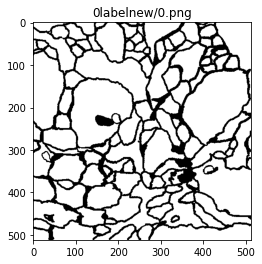

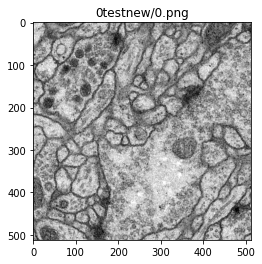

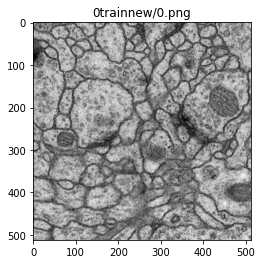

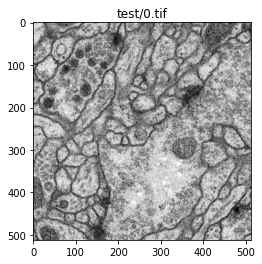

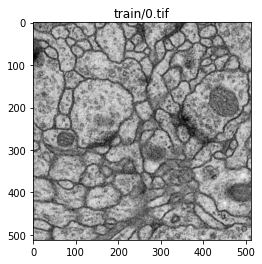

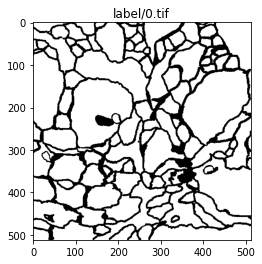

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img

    
repertoire={}
for repertoire in os.listdir(input_path):
    if not repertoire.startswith('.'):
      path = input_path + repertoire
      if repertoire.startswith('0'):
        imagepath = path + "/0.png"
        titre=repertoire + "/0.png"
      else:
        imagepath = path + "/0.tif"
        titre=repertoire + "/0.tif"
             
      image = plt.imread(imagepath) 
      
      plt.imshow(image,cmap='gray')
      plt.title(titre)
      plt.show()

### **On constate que les images du mask (label) sont sur un fond blanc contrairement aux images du train et du test.**

### Explications différence du nombre de photos entre les anciens (tif) et nouveaux (png) répertoires : 
Nous n'avons pas le même nombre de photos dans chaque répertoire , car il y avait une photo n'ayant pas le format tif dans chacun des répertoire d'origine, que nous ne retrouvons pas dans les nouveaux répertoires car nous n'en avons pas besoin pour notre étude

# IV- Appliquer la data augmentation

L’entraînement d’un réseau de neurones profond sur très peu d’images est souvent challengeant : le modèle n’ayant accès qu’à un nombre limité d’observations, il va avoir tendance à faire de “l’overfitting”, c’est à dire sur-apprendre à partir de l’échantillon d’entraînement, sans pour autant être capable d’émettre des prédictions pertinentes sur de nouvelles images – dans ce cas les performances sont faibles sur l’échantillon de test alors qu’elles étaient bonnes sur les images d’entraînement. 

Ce phénomène est bien connu des Data Scientists, qui le résolvent souvent en augmentant la taille du dataset et/ou réduisant le nombre de paramètres du modèle. 

La première méthode est souvent difficile à mettre en place car le travail de recueil/labellisation de nouvelles observations est laborieux.

La seconde possibilité est envisageable pour un problème de reconnaissance d’images, cependant les modèles même les moins complexes peuvent contenir des centaines de milliers de paramètres, donc difficile à réaliser !
Comme la **Data Augmentation permet de générer de nouvelles images labellisées à partir de celles déjà disponibles, c’est une solution relativement facile à mettre en place, et les résultats peuvent être surprenants.**

## Mise en place de la data augmentation

Dans les tâches d'apprentissage en profondeur, beaucoup de données sont nécessaires pour entraîner le modèle DNN, lorsque l'ensemble de données n'est pas assez grand, l'augmentation des données doit être appliquée.

``keras.preprocessing.image.ImageDataGenerator`` est un générateur de données, qui peut alimenter le DNN avec des données telles que: (données, étiquette), il peut également augmenter les données en même temps.

Il est très pratique pour nous d'utiliser ``keras.preprocessing.image.ImageDataGenerator`` pour augmenter les données en implémentant la rotation d'image, le décalage, la redimensionnement, etc.

**Pour les tâches de segmentation d'image, l'image et le mask doivent être transformés ensemble !!**

In [ ]:
#ajustement des données pour les iamges (normalisation, vectorisation)
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)


#data augmentation
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
   
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)


#fonction pour le test
def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img


def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr

#visualisation
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255


#sauvegarde des prédictions
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)


# Définition du générateur de données



On peut faire de la Data Augmentation en utilisant la fonction ImageDataGenerator et en modifiant certains paramètres :

   **rotation_range** pour faire pivoter une image de façon aléatoire sur une plage entre 0 et la valeur choisis (maximum 180 degré)
   
   **width_shift et height_shift** sont des plages (en fraction de la largeur ou de la hauteur totale) à l’intérieur desquelles on peut redimensionner aléatoirement des images verticalement ou horizontalement.
    
   **shear_range** est une plage permettant de rogner(découper) de manière aléatoire l’image
    
   **zoom_range** permet de zoomer de manière aléatoire à l’intérieur des images
    
   **horizontal_flip** retourne horizontalement des images de manière aléatoire (certaines seront retourner d’autres non)
    
   **fill_mode** est la stratégie utilisée pour remplir les pixels nouvellement créés, qui peuvent apparaître après un pivotage, un rognage, etc
    

In [ ]:
#lancement de la data augmentaion
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/train','image','label',data_gen_args,save_to_dir = "/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/train/aug4")


### Visualisation du résultat de la data augmentaion

In [ ]:

# 60 images modifiées et leurs masks 
num_batch = 3
for i,batch in enumerate(myGenerator):
  if(i >= num_batch):
    break

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


# création  .npy data contenant les images et les masks 

In [ ]:


image_arr,mask_arr = geneTrainNpy("/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/train/aug4","/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/train/aug4/")

np.save("/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/image_arr.npy",image_arr)
np.save("/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/mask_arr.npy",mask_arr)


# création du réseau unet



**Le U-Net est une architecture à réseau convolutionnel pour une segmentation rapide et précise des images**. Il a la particularité d’avoir une architecture symétrique composée d’une partie de “**contraction**”, qui va permettre de détecter le contexte et les objets, et une partie “**expansion**” composée de succession d’up-convolution qui fait le chemin inverse qui va permettre de reconstituer l’image composée de macro-features extraites de la partie “contraction” et finalement de localiser précisément le contour des objets détectés.



Il a une forme en «U». 

L'architecture U-Net est symétrique et son fonctionnement est un peu similaire aux encodeurs automatiques. Il peut être réduit en trois parties principales: 
- le chemin de contraction (sous-échantillonnage), 
- le goulot d'étranglement 
- le chemin d'expansion (de suréchantillonnage). 

Dans les auto-codeurs, la partie codeur du réseau neuronal comprime l'entrée dans une représentation d'espace latent, puis un décodeur construit la sortie à partir de la représentation compressée ou codée. Mais il y a une légère différence, contrairement aux structures codeur-décodeur régulières, les deux parties ne sont pas découplées. Les connexions par sauts sont utilisées pour transférer des informations à granularité fine des couches de bas niveau du chemin d'analyse vers les couches de haut niveau du chemin de synthèse, car ces informations sont nécessaires pour générer des reconstructions qui ont des détails précis.



![image](/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/reseau.JPG)

from IPython.display import IFrame, display
filepath = "/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/reseau.JPG"
IFrame(filepath, width=900, height=400)

In [ ]:
from IPython.display import IFrame, display
filepath = "/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/reseau.JPG"
IFrame(filepath, width=900, height=400)

In [ ]:
![image]("/content/drive/MyDrive/microsoft_ia/Google 'Drive'/projets/ia/Segmentation 'des Images de la Microscopie Électronique'/reseau.JPG")

/bin/bash: -c: line 0: syntax error near unexpected token `"/content/drive/MyDrive/microsoft_ia/Google 'Drive'/projets/ia/Segmentation 'des Images de la Microscopie Électronique'/reseau.JPG"'
/bin/bash: -c: line 0: `[image]("/content/drive/MyDrive/microsoft_ia/Google 'Drive'/projets/ia/Segmentation 'des Images de la Microscopie Électronique'/reseau.JPG")'


Nous sommes ici face à une tâche de classification binaire.

La forme d'entrée de l'image et du masque sont les mêmes: (batch_size, rows, cols, channel = 1)


Nous allons répéter le processus down_block et up_block quatre fois, qui est ensuite suivi par le dernier calque convolutionnel qui donne le masque prédit final. Dans ce cas, l'optimiseur «Adam» est un bon choix pour un optimiseur et «binary_crossentropy» peut être utilisé comme fonction de perte. 

Chemin de contrat
Le chemin contractant est composé de quatre blocs où chaque bloc est composé de:

Couche de convolution 3x3 + fonction d'activation (relu)
Couche de convolution 3x3 + fonction d'activation (relu) 
Couche de mise en commun 2x2 Max

Chemin d'extension
Le chemin en expansion est également composé de 4 blocs. Chacun de ces blocs est composé de:

Couche DeConvolution ou UpSampling2D avec stride 2
L'image est concaténée avec l'image correspondante du chemin contractant
Couche de convolution 3x3 + fonction d'activation [La suppression est facultative]
Couche de convolution 3x3 + fonction d'activation [La suppression est facultative]

In [ ]:
#ci dessous le modèle du fichier model.py

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #sigmoid car binaire
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    return model

In [ ]:
# Entraînement du modèle

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/train','image','label',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
2000/2000 [==============================] - 376s 169ms/step - loss: 0.3100 - accuracy: 0.8753

Epoch 00001: loss improved from inf to 0.25754, saving model to unet_membrane.hdf5
Epoch 2/5
2000/2000 [==============================] - 345s 173ms/step - loss: 0.2043 - accuracy: 0.9355

Epoch 00002: loss improved from 0.25754 to 0.19539, saving model to unet_membrane.hdf5
Epoch 3/5
2000/2000 [==============================] - 345s 172ms/step - loss: 0.1722 - accuracy: 0.9504

Epoch 00003: loss improved from 0.19539 to 0.16605, saving model to unet_membrane.hdf5
Epoch 4/5
2000/2000 [==============================] - 345s 172ms/step - loss: 0.1495 - accuracy: 0.9590

Epoch 00004: loss improved from 0.16605 to 0.14493, saving model to unet_membrane.hdf5
Epoch 5/5
2000/2000 [==============================] - 344s 172ms/step - loss: 0.1325 - accuracy: 0.9640

Epoch 00005: loss improved from 0.14493 to 0.12893, saving model to unet_membrane.hdf5


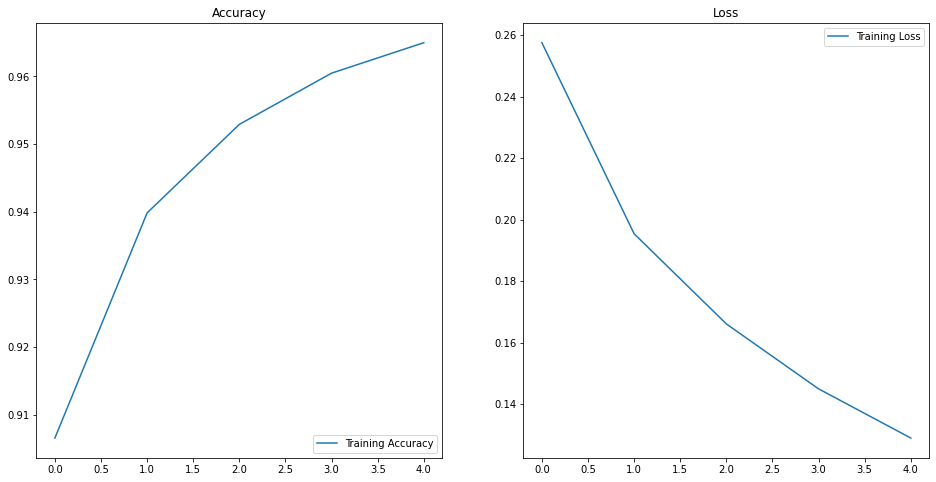

In [ ]:

import matplotlib.pyplot as plt 
from keras.callbacks import History


acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

loss = history.history['loss']
#val_loss = history.history['val_loss']

#saisir le nombre en fonction du nombre d'epochs calculé
epochs= len(loss)
epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

#print("Nous avons une Accuracy de : {}".format(score))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()




Nous avons un eaccuracy de 96,4% et une perte de 0,1325

## Train with data generator

L'étape suivante consiste à entraîner le modèle sur un nombre décent d'époch(5) et à faire des prédictions.

In [ ]:
model.save('//content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/unet_membrane2.hdf5')

# Train with npy file

In [ ]:
imgs_train,imgs_mask_train = geneTrainNpy("/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/train/aug4/","/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/train/aug4/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
model = unet()

testGene = testGenerator("data/membrane/test")
model = unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/membrane/test",results)

NameError: ignored

In [ ]:
imgs_train,imgs_mask_train = geneTrainNpy("/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/train/aug4/","/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/train/aug4/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
model = unet()

testGene = testGenerator("data/membrane/test")
model = unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/membrane/test",results)
model_checkpoint = ModelCheckpoint('unet_train.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit(imgs_train, imgs_mask_train, batch_size=20, epochs=50, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
model.save("/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/modelI")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_48[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_49[0][0]                  
____________________________________________________________________________________________

# prédiction du modèle et sauvegarde des résultats prédits

In [ ]:


testGene = testGenerator("/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/test")
model = unet()
model.load_weights("unet_membrane2.hdf5")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/test",results)



Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 256, 256, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_72[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_73[0][0]                  
____________________________________________________________________________________________

OSError: ignored

In [ ]:
path_data_test = '/content/drive/MyDrive/microsoft_ia/Google Drive/projets/ia/Segmentation des Images de la Microscopie Électronique/data/membrane/test'

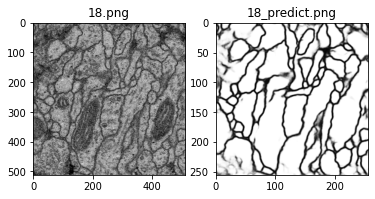

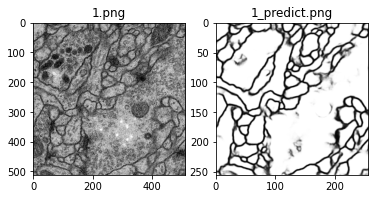

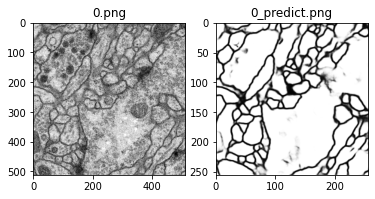

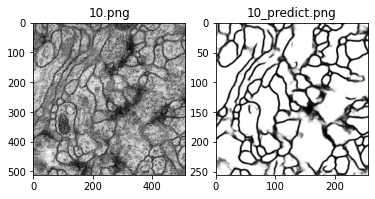

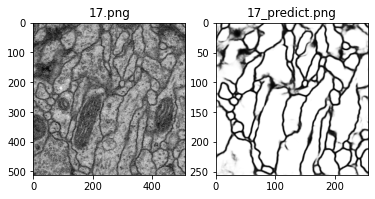

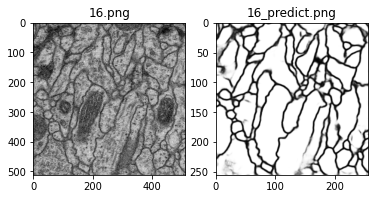

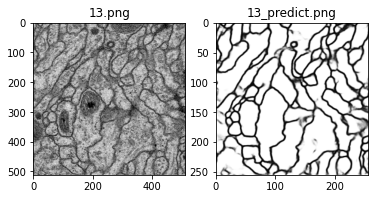

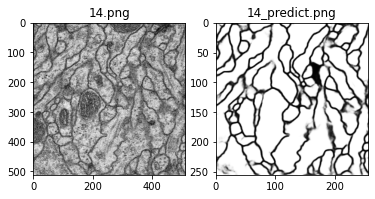

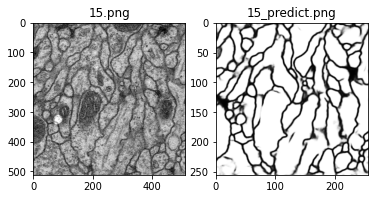

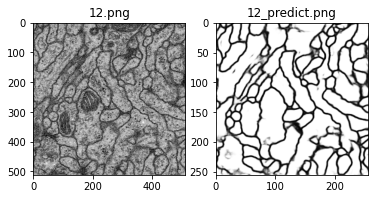

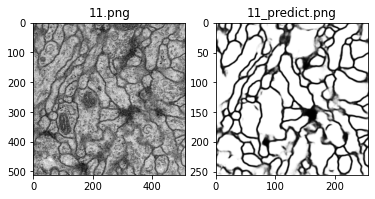

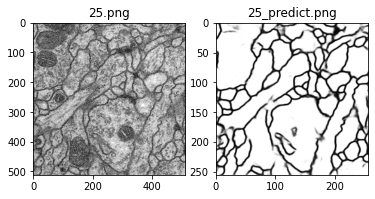

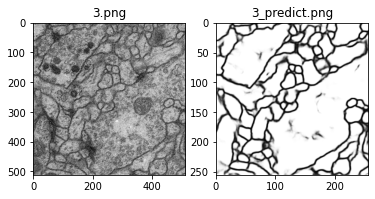

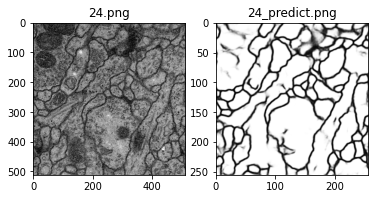

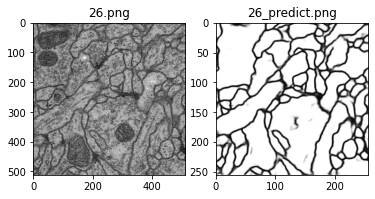

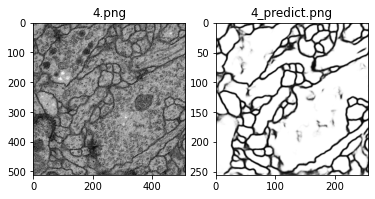

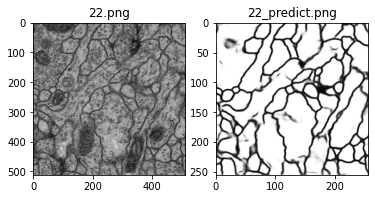

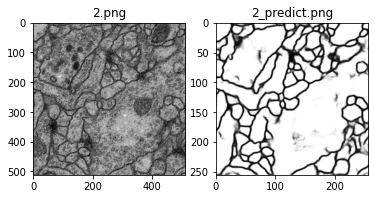

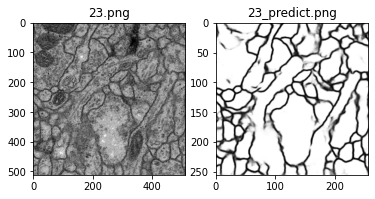

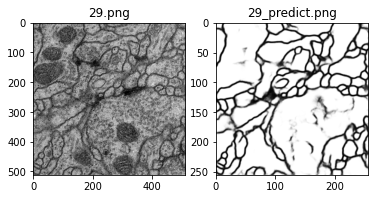

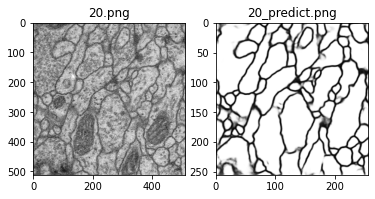

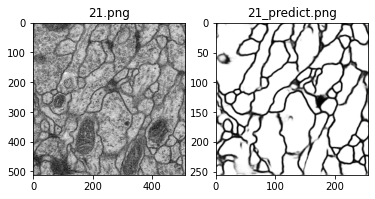

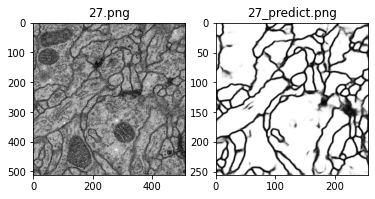

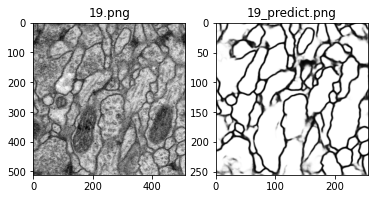

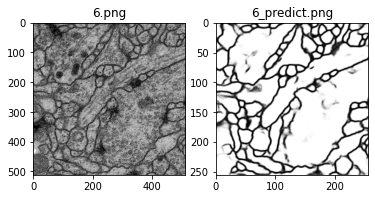

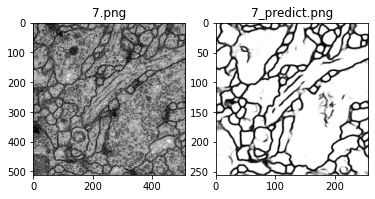

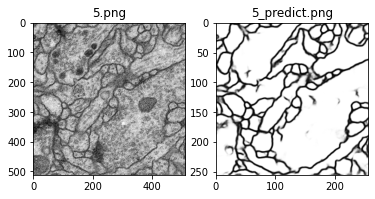

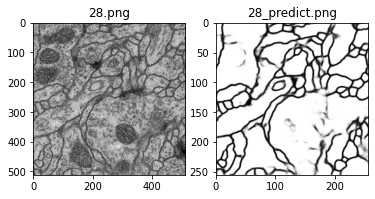

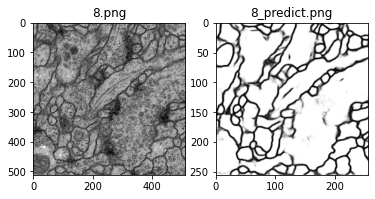

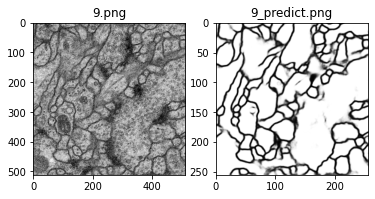

In [ ]:


for img in os.listdir(path_data_test):
  if not '_predict' in img:
    imagepath_test = path_data_test +'/'+ img
    #la fonction split retourne un eliste sur les éléments qui sont avant le .(endroit du split)
    name = img.split('.')
    #la liste permet d'avoir un index, ce que l'on obtient grace au split(ce qui est avant le point et après le point)
    imagepath_test_pred = path_data_test +'/'+ name[0] +'_predict.png' 
    image = plt.imread(imagepath_test)
    image_pred = plt.imread(imagepath_test_pred)
        
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image, cmap='gray')
    axarr[0].set_title(img)
    axarr[1].imshow(image_pred, cmap='gray')
    axarr[1].set_title(name[0]+'_predict.png')
    plt.show()